# Euclidean space

* Load original embeddings
* Euclidean MDS

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import re, seaborn as sns
from sklearn.manifold import MDS
from scipy import stats
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

data_dir = '../data'
output_dir = '../outputs'

In [2]:
input_distance_matrix = pd.read_csv(os.path.join(data_dir, 'coef_embed.csv'), header=None).to_numpy()
input_distance_matrix.shape

(49, 49)

In [3]:
embedding = MDS(n_components=3)
transformed_dist = embedding.fit_transform(input_distance_matrix)
# eu_dist = np.corrcoef(transformed_dist, rowvar=True)
# eu_dist = 1 - abs(eu_dist)
eu_dist = distance_matrix(transformed_dist, transformed_dist)

stats.spearmanr(eu_dist.flatten(),input_distance_matrix.flatten()) 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


SpearmanrResult(correlation=0.3673251091282551, pvalue=1.3804362966543654e-77)

In [4]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [5]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [6]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


# Analysis

1. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
2. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        


In [7]:
### normalize embeddings and transform concept embeddings to loadings in feature space
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
concept_in_feat_coord = normalized_embeddings@transformed_dist
np.array(concept_in_feat_coord).shape

(1854, 3)

In [8]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(concept_in_feat_coord).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,cr,bigcat,cat_name
0,0,0.932652,-0.565824,0.167848,0.779739,1,animal
1,1,1.212983,-0.434775,-0.180222,0.798485,13,home decor
2,2,1.281751,-0.166190,0.457923,0.752845,18,musical instrument
4,4,0.780076,0.210157,0.233160,0.794466,9,electronic device
5,5,0.682448,0.555517,0.455069,0.806000,12,furniture
...,...,...,...,...,...,...,...
1847,1847,-0.227921,-0.633052,-0.500712,0.803129,24,toy
1848,1848,0.778062,0.183646,0.569998,0.765881,10,food
1850,1850,0.810498,-0.006663,0.104576,0.843158,10,food
1851,1851,0.882541,-0.314800,-0.086195,0.800163,1,animal


In [9]:
transformed_dist.shape

(49, 3)

<IPython.core.display.Javascript object>


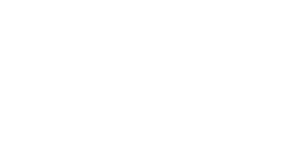

In [10]:
from matplotlib import animation
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# ax.axes.set_xlim3d(left=-30, right=20) 
# ax.axes.set_ylim3d(bottom=-30, top=20) 
# ax.axes.set_zlim3d(bottom=-30, top=20) 

concept_cat = ax.scatter(mean_concept_in_feat_cat_na[0], mean_concept_in_feat_cat_na[1], mean_concept_in_feat_cat_na[2], alpha=0.6) 
ax.scatter(transformed_dist.T[0], transformed_dist.T[1], transformed_dist.T[2], color='red')

# def animate(frame):
#     ax.view_init(60, frame)
#     plt.pause(.0001)
#     return fig

# anim = animation.FuncAnimation(fig, animate, frames=50, interval=.1, repeat=True)
# anim.save('../outputs/feat_concept_rotate.gif', writer='pillow')

plt.show()

<IPython.core.display.Javascript object>


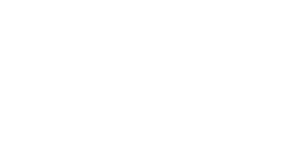

In [11]:
### color by categories: repeat color assignment
import matplotlib.colors as mcolors
%matplotlib notebook

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

groups = mean_concept_in_feat_cat_na.groupby("cat_name")
i = 3
for name, group in groups:
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7, color=color_names[i])
    i = i+6
plt.legend(bbox_to_anchor=(0.13,0.7))

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


### Cartesian

In [12]:
coordinates = mean_concept_in_feat_cat.loc[:, 0:2]
coordinates

,0,1,2
0,0.932652,-0.565824,0.167848
1,1.212983,-0.434775,-0.180222
2,1.281751,-0.166190,0.457923
3,1.105044,-0.339570,0.246531
4,0.780076,0.210157,0.233160
...,...,...,...
1849,1.112123,-0.698278,0.627446
1850,0.810498,-0.006663,0.104576
1851,0.882541,-0.314800,-0.086195
1852,0.823903,0.133033,0.760764


In [13]:
### linreg: cartesian coordinates and z-score memorability
# Euclidean: R^2 = 0.271, adjusted = 0.265
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(coordinates, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     65.73
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.21e-40
Time:                        17:37:08   Log-Likelihood:                -2536.8
No. Observations:                1854   AIC:                             5082.
Df Residuals:                    1850   BIC:                             5104.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3668      0.047     -7.836      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [14]:
### create a new table to store all regression results
results_index = ['rsquared', 'rsquared_adj', 'coef', 'pvalues', 'AIC', 'BIC', 'F-statistic', 'F-stats-prob', 'Log-Likelihood']
results = pd.DataFrame({'cart_coord_mem':[res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]}, index=results_index)
results

,cart_coord_mem
rsquared,0.09632
rsquared_adj,0.094854
coef,"[-0.36677520639633004, 0.3076624275314951, 0.2..."
pvalues,"[7.77226553851174e-15, 6.980586641682155e-13, ..."
AIC,5081.65201
BIC,5103.752413
F-statistic,65.72792
F-stats-prob,0.0
Log-Likelihood,-2536.826005


### Polar coordinates

In [15]:
# ### Polar coordinates of concepts in hyperbolic feature space
# r, theta, rho = cart_to_polar(coordinates.values).T
# plt.hist2d(theta, rho,
#            bins = 20)

### Radius
small R^2, with concepts closer to the core/origin being more memorable

<IPython.core.display.Javascript object>


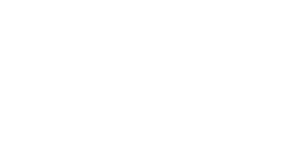

(array([ 17.,  57., 109., 191., 305., 373., 417., 263., 108.,  14.]),
 array([0.09878971, 0.28164162, 0.46449354, 0.64734546, 0.83019738,
        1.01304929, 1.19590121, 1.37875313, 1.56160504, 1.74445696,
        1.92730888]),
 <BarContainer object of 10 artists>)

In [16]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((coordinates**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [17]:
### Radius vs. memorability
# Euclidean: R^2 = 0.006, adjsuted = 0.005
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary(xname=['radius','const']))

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.648
Date:                Sun, 27 Nov 2022   Prob (F-statistic):             0.0563
Time:                        17:37:09   Log-Likelihood:                -2628.9
No. Observations:                1854   AIC:                             5262.
Df Residuals:                    1852   BIC:                             5273.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.1370      0.072     -1.910      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [18]:
results['radius_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]
results


,cart_coord_mem,radius_mem
rsquared,0.09632,0.001966
rsquared_adj,0.094854,0.001427
coef,"[-0.36677520639633004, 0.3076624275314951, 0.2...","[-0.13696061535799886, 0.1513459462063445]"
pvalues,"[7.77226553851174e-15, 6.980586641682155e-13, ...","[0.05628363532292681, 0.06696508041816104]"
AIC,5081.65201,5261.775518
BIC,5103.752413,5272.82572
F-statistic,65.72792,3.648216
F-stats-prob,0.0,0.056284
Log-Likelihood,-2536.826005,-2628.887759


### KMeans

In [19]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(coordinates)
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)
print(inertia)

[1396.5923068631585, 924.1268417313123, 728.8587059847657, 614.4274871527041, 516.0320747322887, 451.87090100300276, 414.9761947785768, 382.42313530139467, 355.74539307305304, 332.472147017701, 313.7102870217075, 297.91459351932286, 282.39777298775874, 268.9309875251066]


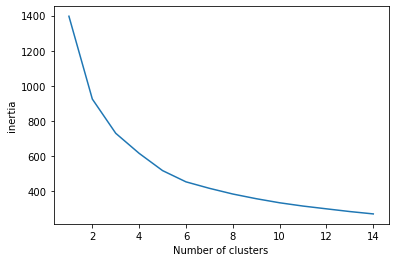

In [20]:
%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()
    

In [79]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(coordinates)
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[ 0.81201634, -0.51641348,  0.4474292 ],
       [ 0.11106794,  0.77967451,  0.67996826],
       [ 0.2226479 ,  0.15469805, -0.13697893],
       [ 1.10514789,  0.16376167,  0.19157994]])

<IPython.core.display.Javascript object>


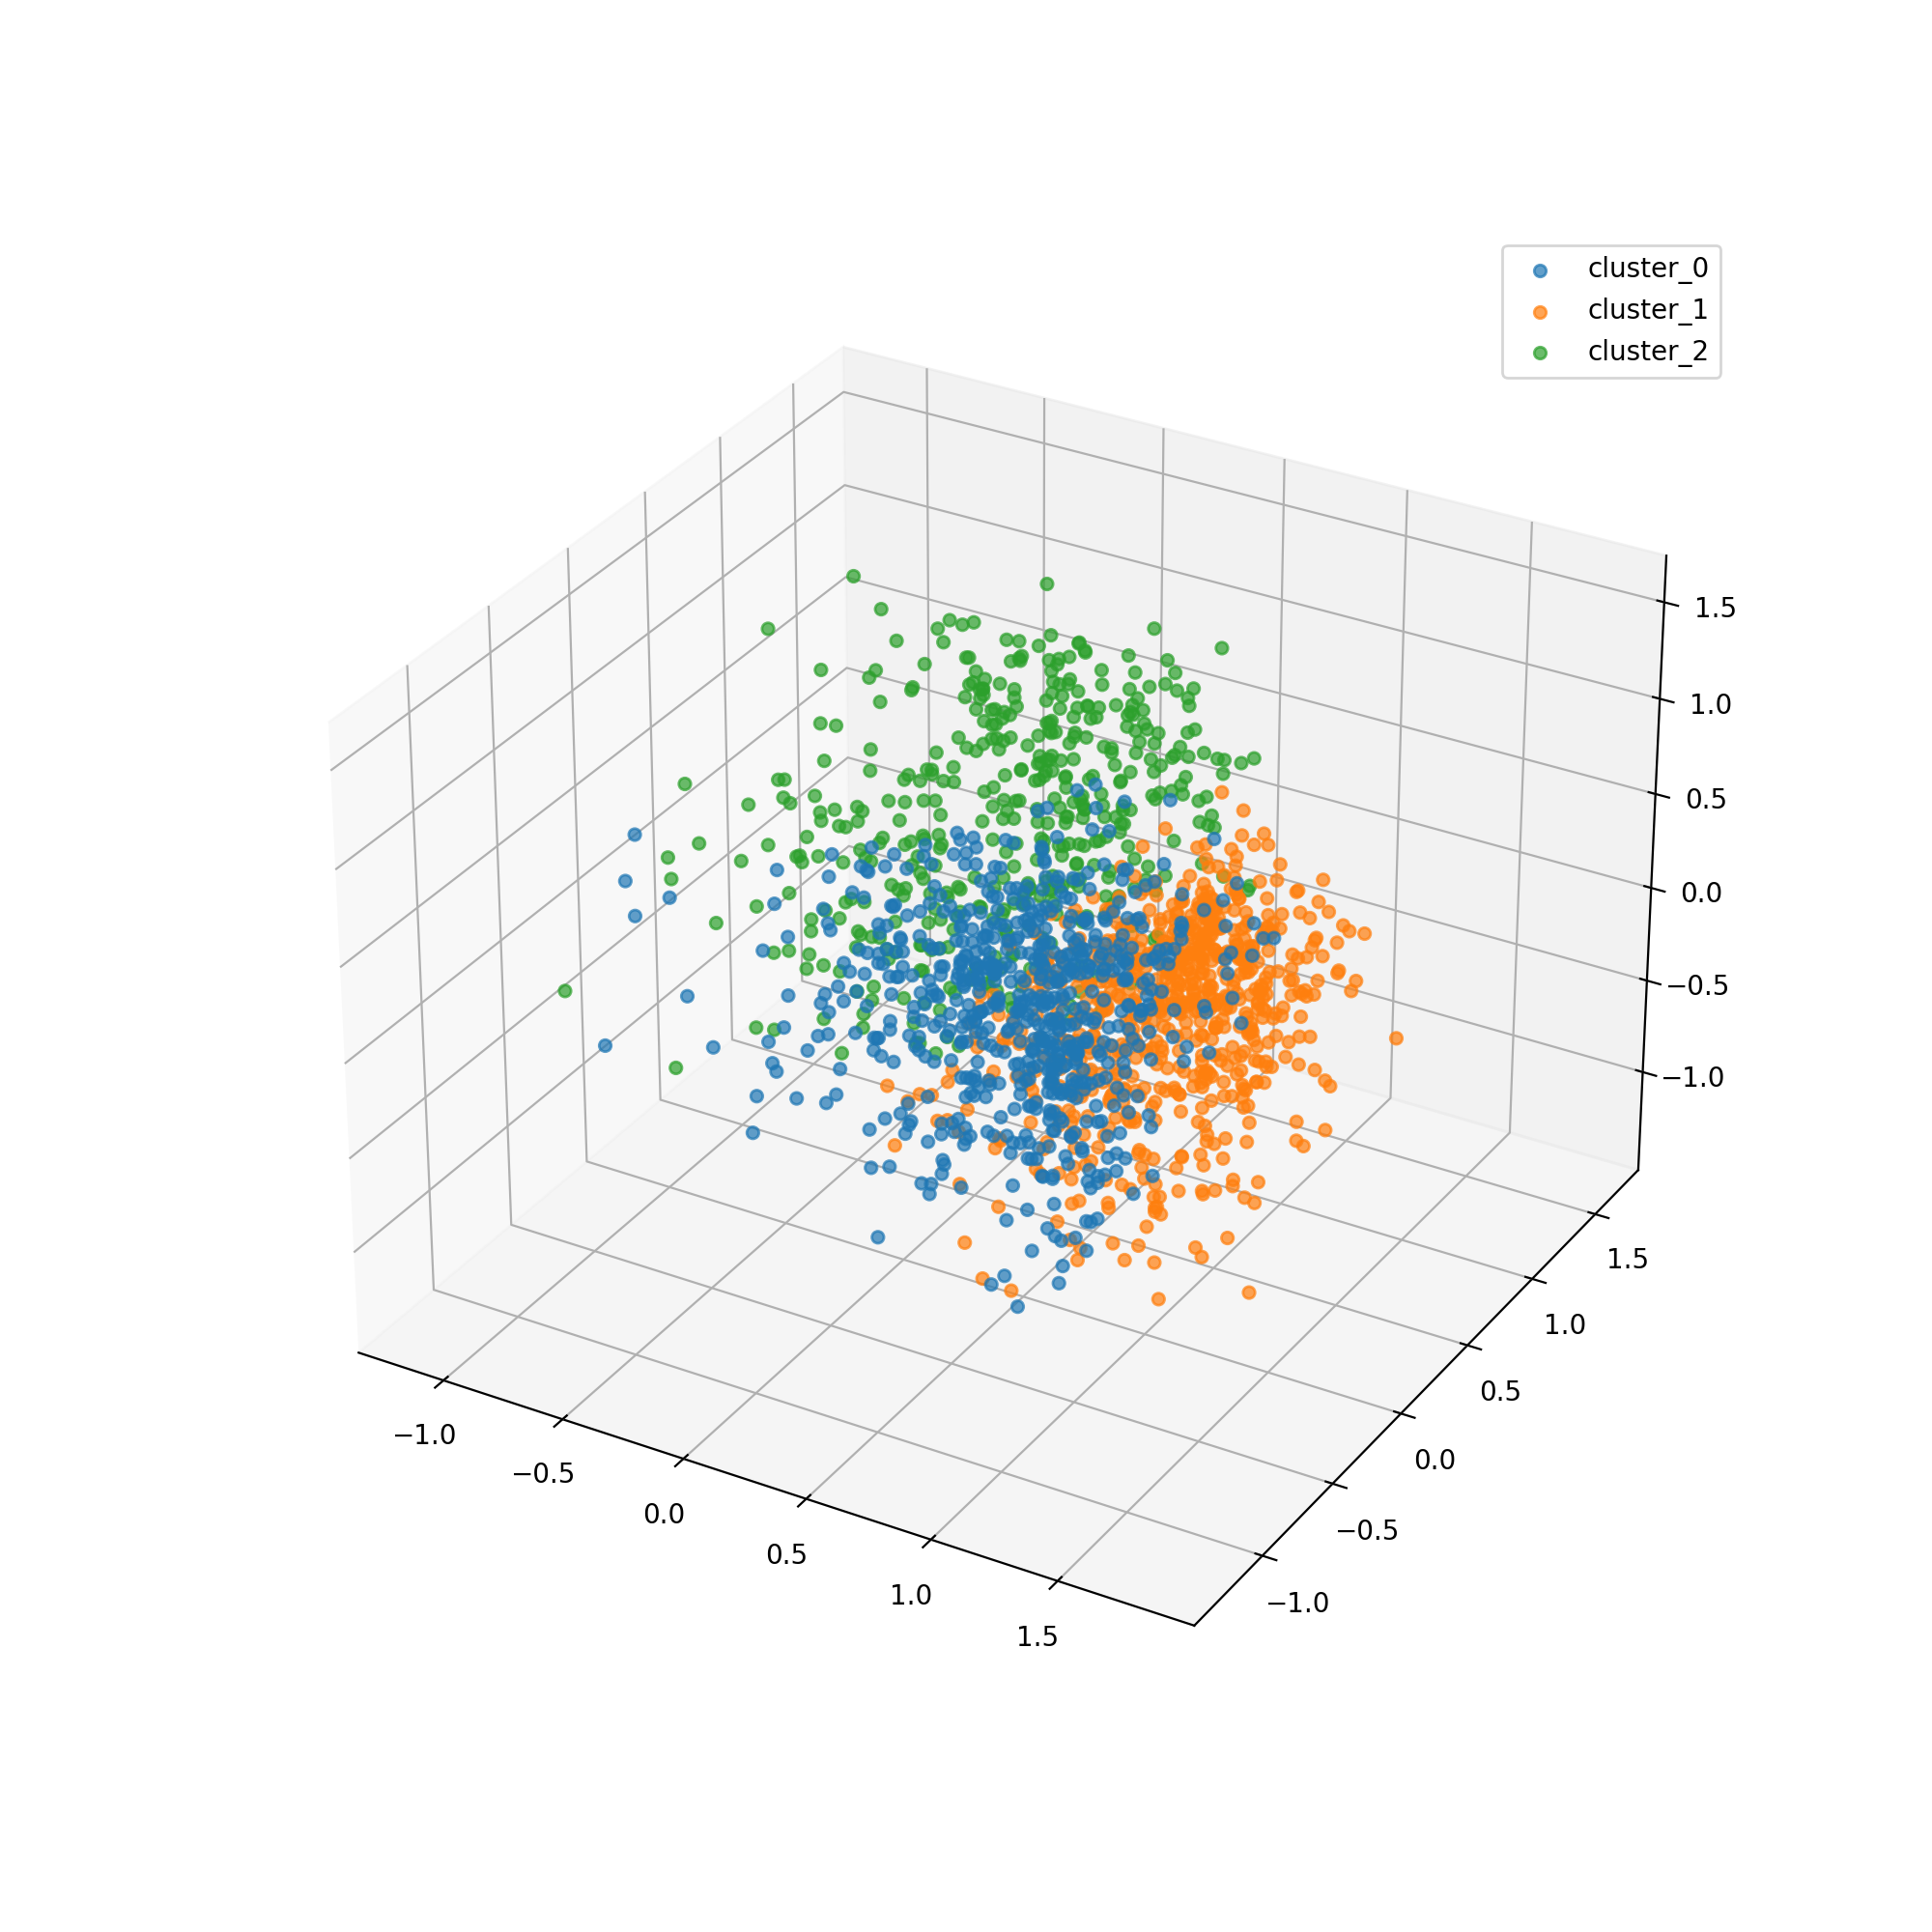

In [22]:
%matplotlib notebook

# plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]

ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.7)
ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.7)
ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.7)
plt.legend()


In [80]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:2], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.885
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.131
Time:                        23:36:20   Log-Likelihood:                -909.54
No. Observations:                 643   AIC:                             1827.
Df Residuals:                     639   BIC:                             1845.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2144      0.126     -1.702      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [81]:
results['cluster_cart_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]
results

,cart_coord_mem,radius_mem,cluster_cart_mem,cluster_radius_mem,cart_typ,radius_typ,cart_typ_mem,radius_typ_mem,cluster_cart_typ_mem,cluster_radius_typ_mem,cart_clust_typ_mem,cart_clust_typ,radius_clust_typ_mem,radius_clust_typ,cluster_cart_clust_typ_mem,cluster_radius_clust_typ_mem
rsquared,0.09632,0.001966,[0.00877366995169171],"[0.0036419268528994353, 0.05948798698046032, 0...",0.130582,0.01596,0.15802,0.033591,"[0.12239807608816577, 0.10488064457843727, 0.1...","[0.10516475049954521, 0.09086691157146987, 0.1...",0.145016,0.200349,0.064084,0.067755,"[0.006771445066373616, 0.185507633266615, 0.19...","[0.0023881395317979504, 0.18105975137731178, 0..."
rsquared_adj,0.094854,0.001427,[0.0041200252096808],"[0.0021658408186074896, 0.05818893723872054, 0...",0.128606,0.015216,0.155466,0.032128,"[0.11540523207293207, 0.09786010061434658, 0.1...","[0.10161381696978156, 0.08731561044479597, 0.1...",0.142423,0.198531,0.062667,0.06705,"[-0.0011427266860855045, 0.17911945784125516, ...","[-0.0015706376922821619, 0.17786076603112944, ..."
coef,"[-0.36677520639633004, 0.3076624275314951, 0.2...","[-0.13696061535799886, 0.1513459462063445]","[[-0.2144002033871237, 0.06303543472547357, -0...","[[-0.1990430617721762, 0.227711846957168], [-0...","[0.8203686845881835, 0.13624645706152913, 0.10...","[0.3985966935986164, -0.44405234047268344]","[-0.59020676005791, 0.2563005303987461, 0.1996...","[-0.1265189154054084, 0.9806025260779756, -0.4...","[[-0.4720194566097644, 0.007461618148827226, -...","[[-0.24174366074105963, 1.796595452599309, -0....","[-0.5375271188941049, 0.17160761531005964, 0.0...","[0.6742721011636571, 0.4651818746278159, 0.727...","[-0.2680349716757884, 2.724890413389214, -0.26...","[0.8212720697268574, -0.9149292770960449]","[[0.037468226031496424, -0.010721827289398463,...","[[-0.005705236688717898, -0.9050540766758358, ..."
pvalues,"[7.77226553851174e-15, 6.980586641682155e-13, ...","[0.05628363532292681, 0.06696508041816104]","[[0.08919938348980509, 0.6858937889583558, 0.0...","[[0.1167070663331515, 0.12939607614558526], [2...","[2.0484281156234236e-41, 0.006441117855259437,...","[4.007280582441415e-06, 9.150146090854304e-06]","[7.701607192962937e-21, 2.3124301395288858e-07...","[0.14161737017872622, 2.2451399324520978e-11, ...","[[0.0004196551372016051, 0.9632243233945467, 0...","[[0.09548533084781019, 8.172538788298154e-14, ...","[5.982934102253554e-18, 0.0008398961736993426,...","[2.1502749360602997e-31, 1.3515687036922782e-2...","[0.0021016423344532987, 1.0415017525215533e-20...","[6.035840102155433e-22, 1.804394091356126e-20]","[[0.7889688616988173, 0.9520282648430693, 0.18...","[[0.9718807760565827, 0.3124411587442683, 0.38..."
AIC,5081.65201,5261.775518,[1827.0885900110627],"[1922.772688809822, 2019.7725478070242, 1220.2...",3580.080468,3740.047665,3539.622722,3718.110057,"[1382.608648534455, 1414.4456102341508, 801.32...","[1388.468034863432, 1418.445840642043, 806.902...",3559.914762,3469.329768,3675.661019,3668.457879,"[1445.3588736798563, 1365.8337245078508, 803.3...","[1443.5914378571529, 1364.6384497387967, 811.6..."
BIC,5103.752413,5272.82572,[1844.9531689080131],"[1931.8080313556466, 2028.947647836674, 1228.4...",3600.834119,3750.42449,3565.564786,3733.675295,"[1403.7512035524107, 1435.6664447374694, 819.8...","[1401.1535678742055, 1431.1783413440344, 818.0...",3585.856825,3490.083419,3691.226257,3678.834704,"[1466.5014286978121, 1387.0545590111694, 821.8...","[1456.2769708679264, 1377.370950440788, 822.76..."
F-statistic,65.72792,3.648216,[1.8853329891057913],"[2.4672863019439246, 45.79346353650295, 68.066...",66.085598,21.441414,61.886326,22.95833,"[17.503332810159154, 14.939105162632725, 18.04...","[29.61608535278418, 25.5869351345526, 30.53993...",55.929747,110.239911,45.225884,96.082174,"[0.8556100724336081, 29.039220264707172, 17.44...","[0.6032518115117855, 56.59911871537203, 27.743..."
F-stats-prob,0.0,0.056284,[0.13075432754244293],"[0.11670706633315803, 2.7139865288650758e-11, ...",0.0,0.000004,0.0

In [82]:
### cluster 0: radius vs. memorability
radius_cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(radius_cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_0.loc[:, 0:2]**2).sum(1)), prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.143
Date:                Sun, 27 Nov 2022   Prob (F-statistic):             0.0767
Time:                        23:36:21   Log-Likelihood:                -910.81
No. Observations:                 643   AIC:                             1826.
Df Residuals:                     641   BIC:                             1835.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2621      0.148     -1.773      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [83]:
results['cluster_radius_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]
results

,cart_coord_mem,radius_mem,cluster_cart_mem,cluster_radius_mem,cart_typ,radius_typ,cart_typ_mem,radius_typ_mem,cluster_cart_typ_mem,cluster_radius_typ_mem,cart_clust_typ_mem,cart_clust_typ,radius_clust_typ_mem,radius_clust_typ,cluster_cart_clust_typ_mem,cluster_radius_clust_typ_mem
rsquared,0.09632,0.001966,[0.00877366995169171],[0.004879054470555477],0.130582,0.01596,0.15802,0.033591,"[0.12239807608816577, 0.10488064457843727, 0.1...","[0.10516475049954521, 0.09086691157146987, 0.1...",0.145016,0.200349,0.064084,0.067755,"[0.006771445066373616, 0.185507633266615, 0.19...","[0.0023881395317979504, 0.18105975137731178, 0..."
rsquared_adj,0.094854,0.001427,[0.0041200252096808],[0.003326603697498709],0.128606,0.015216,0.155466,0.032128,"[0.11540523207293207, 0.09786010061434658, 0.1...","[0.10161381696978156, 0.08731561044479597, 0.1...",0.142423,0.198531,0.062667,0.06705,"[-0.0011427266860855045, 0.17911945784125516, ...","[-0.0015706376922821619, 0.17786076603112944, ..."
coef,"[-0.36677520639633004, 0.3076624275314951, 0.2...","[-0.13696061535799886, 0.1513459462063445]","[[-0.2144002033871237, 0.06303543472547357, -0...","[[-0.26207200748014126, 0.3069667402870686]]","[0.8203686845881835, 0.13624645706152913, 0.10...","[0.3985966935986164, -0.44405234047268344]","[-0.59020676005791, 0.2563005303987461, 0.1996...","[-0.1265189154054084, 0.9806025260779756, -0.4...","[[-0.4720194566097644, 0.007461618148827226, -...","[[-0.24174366074105963, 1.796595452599309, -0....","[-0.5375271188941049, 0.17160761531005964, 0.0...","[0.6742721011636571, 0.4651818746278159, 0.727...","[-0.2680349716757884, 2.724890413389214, -0.26...","[0.8212720697268574, -0.9149292770960449]","[[0.037468226031496424, -0.010721827289398463,...","[[-0.005705236688717898, -0.9050540766758358, ..."
pvalues,"[7.77226553851174e-15, 6.980586641682155e-13, ...","[0.05628363532292681, 0.06696508041816104]","[[0.08919938348980509, 0.6858937889583558, 0.0...","[[0.07673726676241044, 0.08436069185173264]]","[2.0484281156234236e-41, 0.006441117855259437,...","[4.007280582441415e-06, 9.150146090854304e-06]","[7.701607192962937e-21, 2.3124301395288858e-07...","[0.14161737017872622, 2.2451399324520978e-11, ...","[[0.0004196551372016051, 0.9632243233945467, 0...","[[0.09548533084781019, 8.172538788298154e-14, ...","[5.982934102253554e-18, 0.0008398961736993426,...","[2.1502749360602997e-31, 1.3515687036922782e-2...","[0.0021016423344532987, 1.0415017525215533e-20...","[6.035840102155433e-22, 1.804394091356126e-20]","[[0.7889688616988173, 0.9520282648430693, 0.18...","[[0.9718807760565827, 0.3124411587442683, 0.38..."
AIC,5081.65201,5261.775518,[1827.0885900110627],[1825.6100433281065],3580.080468,3740.047665,3539.622722,3718.110057,"[1382.608648534455, 1414.4456102341508, 801.32...","[1388.468034863432, 1418.445840642043, 806.902...",3559.914762,3469.329768,3675.661019,3668.457879,"[1445.3588736798563, 1365.8337245078508, 803.3...","[1443.5914378571529, 1364.6384497387967, 811.6..."
BIC,5103.752413,5272.82572,[1844.9531689080131],[1834.5423327765818],3600.834119,3750.42449,3565.564786,3733.675295,"[1403.7512035524107, 1435.6664447374694, 819.8...","[1401.1535678742055, 1431.1783413440344, 818.0...",3585.856825,3490.083419,3691.226257,3678.834704,"[1466.5014286978121, 1387.0545590111694, 821.8...","[1456.2769708679264, 1377.370950440788, 822.76..."
F-statistic,65.72792,3.648216,[1.8853329891057913],[3.1428078462986666],66.085598,21.441414,61.886326,22.95833,"[17.503332810159154, 14.939105162632725, 18.04...","[29.61608535278418, 25.5869351345526, 30.53993...",55.929747,110.239911,45.225884,96.082174,"[0.8556100724336081, 29.039220264707172, 17.44...","[0.6032518115117855, 56.59911871537203, 27.743..."
F-stats-prob,0.0,0.056284,[0.13075432754244293],[0.0767372667624084],0.0,0.000004,0.0,0.0,"[1.8580125945571612e-13, 1.4887428082202147e-1...","[6.906484759754662e-13, 2.562305448289995e-11,...",0.0,0.0,0.0,0.0,"[0.49051590446840987, 9.123822702680808e-22, 7...","[0.54742439800

In [84]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:2], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     23.52
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.11e-13
Time:                        23:36:24   Log-Likelihood:                -393.61
No. Observations:                 300   AIC:                             795.2
Df Residuals:                     296   BIC:                             810.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.6559      0.146     -4.505      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [85]:
row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [86]:
### cluster 1: radius vs. memorability
radius_cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(radius_cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_1.loc[:, 0:2]**2).sum(1)), prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     28.68
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.71e-07
Time:                        23:36:26   Log-Likelihood:                -411.90
No. Observations:                 300   AIC:                             827.8
Df Residuals:                     298   BIC:                             835.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.0882      0.203      5.356      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [87]:
row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [88]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:2], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     5.902
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           0.000628
Time:                        23:36:27   Log-Likelihood:                -438.24
No. Observations:                 315   AIC:                             884.5
Df Residuals:                     311   BIC:                             899.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1933      0.152     -1.274      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [89]:
row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [90]:
### cluster 2: radius vs. memorability
radius_cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(radius_cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_2.loc[:, 0:2]**2).sum(1)), prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8192
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.366
Time:                        23:36:28   Log-Likelihood:                -446.55
No. Observations:                 315   AIC:                             897.1
Df Residuals:                     313   BIC:                             904.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1933      0.214      0.905      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [92]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:2], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     13.57
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.43e-08
Time:                        23:38:16   Log-Likelihood:                -825.87
No. Observations:                 596   AIC:                             1660.
Df Residuals:                     592   BIC:                             1677.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.8965      0.178     -5.035      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [91]:
row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [93]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2)+ sum((zscore_mem_3 - zscore_mem_3.mean())**2))
#  
#  
results.iloc[0]['cluster_cart_mem'].append(r_squared)
r_squared

0.06402363016651436

In [36]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
# + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)
# + sum((zscore_mem_3 - zscore_mem_3.mean())**2)
results.iloc[0]['cluster_radius_mem'].append(r_squared)
r_squared

0.056647101657702814

### Typicality

In [37]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [38]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,cr,bigcat,cat_name,typicality
0,0,0.932652,-0.565824,0.167848,0.779739,1,animal,0.810913
1,1,1.212983,-0.434775,-0.180222,0.798485,13,home decor,0.247628
2,2,1.281751,-0.166190,0.457923,0.752845,18,musical instrument,0.624589
4,4,0.780076,0.210157,0.233160,0.794466,9,electronic device,0.522380
5,5,0.682448,0.555517,0.455069,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...
1847,1847,-0.227921,-0.633052,-0.500712,0.803129,24,toy,0.246697
1848,1848,0.778062,0.183646,0.569998,0.765881,10,food,0.786900
1850,1850,0.810498,-0.006663,0.104576,0.843158,10,food,0.770485
1851,1851,0.882541,-0.314800,-0.086195,0.800163,1,animal,0.764335


In [39]:
### Cartesian coordinates vs. typicality
# Euclidean: R^2 = 0.492, adjusted = 0.485
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped.loc[:, 0:2], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     66.09
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           8.19e-40
Time:                        17:37:11   Log-Likelihood:                -1786.0
No. Observations:                1324   AIC:                             3580.
Df Residuals:                    1320   BIC:                             3601.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.8204      0.059     13.960      0.0

In [40]:
### Radius vs. typicality
# Euclidean: R^2 = 0.023, adjusted = 0.023
# normalized: R^2 = 0.388, adjusted = 0.388

concept_radius_typ = np.sqrt((grouped.loc[:, 0:2]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius', 'const']))
results['radius_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     21.44
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           4.01e-06
Time:                        17:37:11   Log-Likelihood:                -1868.0
No. Observations:                1324   AIC:                             3740.
Df Residuals:                    1322   BIC:                             3750.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius         0.3986      0.086      4.630      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
### Cartesian coordinates and typicality vs. memorability
# Euclidean: R^2 = 0.301, adjusted = 0.292
# normalized: R^2 = 0.107, adjusted = 0.104

zscore_mem = stats.zscore(grouped['cr'])
idx = [i for i in range(0, 3)]
idx.append('typicality')
mean_concept_constant = sm.add_constant(np.array(grouped[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['x', 'y', 'z', 'typicality', 'const']))
results['cart_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     61.89
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           5.74e-48
Time:                        17:37:11   Log-Likelihood:                -1764.8
No. Observations:                1324   AIC:                             3540.
Df Residuals:                    1319   BIC:                             3566.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x             -0.5902      0.062     -9.523      0.0

In [42]:
### Radius and typicality vs. memorability
# Euclidean: R^2 = 0.041, adjusted = 0.040
# normalized: R^2 = 0.046, adjusted = 0.044

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_typ, grouped['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius','typicality', 'const']))
results['radius_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     22.96
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.58e-10
Time:                        17:37:11   Log-Likelihood:                -1856.1
No. Observations:                1324   AIC:                             3718.
Df Residuals:                    1321   BIC:                             3734.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.1265      0.086     -1.471      0.1

##### Cluster level typicality

In [118]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,cr,bigcat,cat_name,label,typicality
0,0,0.932652,-0.565824,0.167848,0.779739,1,animal,0,0.810913
1,1,1.212983,-0.434775,-0.180222,0.798485,13,home decor,3,0.247628
2,2,1.281751,-0.166190,0.457923,0.752845,18,musical instrument,3,0.624589
3,4,0.780076,0.210157,0.233160,0.794466,9,electronic device,3,0.522380
4,5,0.682448,0.555517,0.455069,0.806000,12,furniture,3,0.509185
...,...,...,...,...,...,...,...,...,...
1319,1847,-0.227921,-0.633052,-0.500712,0.803129,24,toy,2,0.246697
1320,1848,0.778062,0.183646,0.569998,0.765881,10,food,3,0.786900
1321,1850,0.810498,-0.006663,0.104576,0.843158,10,food,3,0.770485
1322,1851,0.882541,-0.314800,-0.086195,0.800163,1,animal,0,0.764335


In [119]:
### cluster 0: cartesian coordinates + typicality vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[idx], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     17.56
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           1.88e-13
Time:                        00:40:54   Log-Likelihood:                -650.83
No. Observations:                 482   AIC:                             1312.
Df Residuals:                     477   BIC:                             1333.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4638      0.154     -3.019      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [120]:
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['typicality'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:2], prepend=False)
mod_0_typ = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0_typ = mod_0_typ.fit()
print(res_0_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     41.05
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           1.28e-23
Time:                        00:40:54   Log-Likelihood:                -628.68
No. Observations:                 482   AIC:                             1265.
Df Residuals:                     478   BIC:                             1282.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.1819      0.136      8.675      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [121]:
### cluster 0: radius + typicality vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:2]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     30.82
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           2.56e-13
Time:                        00:40:55   Log-Likelihood:                -654.75
No. Observations:                 482   AIC:                             1316.
Df Residuals:                     479   BIC:                             1328.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1904      0.163     -1.169      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [122]:
### cluster 1: cartesian coordinates + typicality vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[idx], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     13.58
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           7.99e-10
Time:                        00:40:55   Log-Likelihood:                -269.07
No. Observations:                 207   AIC:                             548.1
Df Residuals:                     202   BIC:                             564.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.8661      0.193     -4.489      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [123]:
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['typicality'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:2], prepend=False)
mod_1_typ = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1_typ = mod_1_typ.fit()
print(res_1_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     22.36
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           1.50e-12
Time:                        00:40:55   Log-Likelihood:                -264.17
No. Observations:                 207   AIC:                             536.3
Df Residuals:                     203   BIC:                             549.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.5171      0.184      2.804      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [124]:
### cluster 1: radius + typicality vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:2]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     12.25
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           9.50e-06
Time:                        00:40:55   Log-Likelihood:                -281.99
No. Observations:                 207   AIC:                             570.0
Df Residuals:                     204   BIC:                             580.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.5352      0.286      1.868      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [125]:
### cluster 2: cartesian coordinates + typicality vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[idx], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     3.533
Date:                Mon, 28 Nov 2022   Prob (F-statistic):            0.00827
Time:                        00:40:56   Log-Likelihood:                -276.79
No. Observations:                 200   AIC:                             563.6
Df Residuals:                     195   BIC:                             580.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4493      0.226     -1.991      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [126]:
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['typicality'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:2], prepend=False)
mod_2_typ = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2_typ = mod_2_typ.fit()
print(res_2_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     10.84
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           1.27e-06
Time:                        00:40:56   Log-Likelihood:                -268.44
No. Observations:                 200   AIC:                             544.9
Df Residuals:                     196   BIC:                             558.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.0520      0.202      5.197      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [127]:
### cluster 2: radius + typicality vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:2]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.4087
Date:                Mon, 28 Nov 2022   Prob (F-statistic):              0.665
Time:                        00:40:57   Log-Likelihood:                -283.37
No. Observations:                 200   AIC:                             572.7
Df Residuals:                     197   BIC:                             582.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1926      0.274      0.702      0.4

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [128]:
### cluster 3: cartesian coordinates + typicality vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[idx], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     12.32
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           1.70e-09
Time:                        00:40:58   Log-Likelihood:                -593.63
No. Observations:                 435   AIC:                             1197.
Df Residuals:                     430   BIC:                             1218.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.8432      0.217     -3.893      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [129]:
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['typicality'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:2], prepend=False)
mod_3_typ = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3_typ = mod_3_typ.fit()
print(res_3_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     6.823
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           0.000168
Time:                        00:40:59   Log-Likelihood:                -607.15
No. Observations:                 435   AIC:                             1222.
Df Residuals:                     431   BIC:                             1239.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.7100      0.221     -3.220      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Taking typicality into account, on cluster level, coordinates and typicality of concepts in euclidean space explained more variance in memorability compared to coordinates only. 

In [130]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2)+ sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2)+ sum((zscore_mem_3 - zscore_mem_3.mean())**2))
# 
# 
results.iloc[0]['cluster_cart_typ_mem'].append(r_squared)
r_squared

0.21476691694784356

In [131]:
r_squared = 1 - (sum((zscore_mem_0 - res_0_typ.fittedvalues)**2) + sum((zscore_mem_1 - res_1_typ.fittedvalues)**2) + sum((zscore_mem_2 - res_2_typ.fittedvalues)**2)+ sum((zscore_mem_3 - res_3_typ.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2)+ sum((zscore_mem_3 - zscore_mem_3.mean())**2))
# 
# 
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

-0.07668243373054229

In [132]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
# + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)
# + sum((zscore_mem_3 - zscore_mem_3.mean())**2)
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

0.08770613072906253

In [56]:
### Cluster and typicality vs. memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     61.05
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           4.37e-26
Time:                        17:37:11   Log-Likelihood:                -1820.2
No. Observations:                1324   AIC:                             3646.
Df Residuals:                    1321   BIC:                             3662.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3020      0.035      8.713      0.0

### Typicality calculated by cluster

In [57]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,cr,bigcat,cat_name,label,typicality
0,0,0.932652,-0.565824,0.167848,0.779739,1,animal,0,0.236506
1,1,1.212983,-0.434775,-0.180222,0.798485,13,home decor,1,0.104999
2,2,1.281751,-0.166190,0.457923,0.752845,18,musical instrument,1,0.036071
3,4,0.780076,0.210157,0.233160,0.794466,9,electronic device,1,0.059719
4,5,0.682448,0.555517,0.455069,0.806000,12,furniture,2,0.140897
...,...,...,...,...,...,...,...,...,...
1319,1847,-0.227921,-0.633052,-0.500712,0.803129,24,toy,0,0.049385
1320,1848,0.778062,0.183646,0.569998,0.765881,10,food,1,0.360776
1321,1850,0.810498,-0.006663,0.104576,0.843158,10,food,1,0.354848
1322,1851,0.882541,-0.314800,-0.086195,0.800163,1,animal,1,0.070957


In [58]:
### overall cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     55.93
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.29e-43
Time:                        17:37:11   Log-Likelihood:                -1775.0
No. Observations:                1324   AIC:                             3560.
Df Residuals:                    1319   BIC:                             3586.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5375      0.061     -8.758      0.0

In [59]:
### overall cartesian vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx[:-1]]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     110.2
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.07e-63
Time:                        17:37:11   Log-Likelihood:                -1730.7
No. Observations:                1324   AIC:                             3469.
Df Residuals:                    1320   BIC:                             3490.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6743      0.056     11.964      0.0

In [60]:
### overall radius and typicality vs. memorability
concept_radius_clus = np.sqrt((clusters.loc[:, 0:2]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     45.23
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.00e-19
Time:                        17:37:11   Log-Likelihood:                -1834.8
No. Observations:                1324   AIC:                             3676.
Df Residuals:                    1321   BIC:                             3691.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2680      0.087     -3.082      0.0

In [61]:
### overall radius vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_clus, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     96.08
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           6.04e-22
Time:                        17:37:11   Log-Likelihood:                -1832.2
No. Observations:                1324   AIC:                             3668.
Df Residuals:                    1322   BIC:                             3679.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.8213      0.084      9.802      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
### cluster 0: cartesian coordinates and typicality vs. memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_0[idx]), prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_clust_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8556
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.491
Time:                        17:37:11   Log-Likelihood:                -717.68
No. Observations:                 507   AIC:                             1445.
Df Residuals:                     502   BIC:                             1467.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0375      0.140      0.268      0.7

In [63]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:2]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_clust_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6033
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.547
Time:                        17:37:11   Log-Likelihood:                -718.80
No. Observations:                 507   AIC:                             1444.
Df Residuals:                     504   BIC:                             1456.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0057      0.162     -0.035      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [64]:
### cluster 1: cartesian coordinates and typicality vs. memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_1[idx]), prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     29.04
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           9.12e-22
Time:                        17:37:11   Log-Likelihood:                -677.92
No. Observations:                 515   AIC:                             1366.
Df Residuals:                     510   BIC:                             1387.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.8055      0.146     -5.509      0.0

In [65]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:2]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     56.60
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           6.20e-23
Time:                        17:37:11   Log-Likelihood:                -679.32
No. Observations:                 515   AIC:                             1365.
Df Residuals:                     512   BIC:                             1377.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.7744      0.144     -5.388      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [66]:
### cluster 2: cartesian coordinates and typicality vs. memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_2[idx]), prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     17.44
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           7.23e-13
Time:                        17:37:11   Log-Likelihood:                -396.66
No. Observations:                 302   AIC:                             803.3
Df Residuals:                     297   BIC:                             821.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7295      0.167     -4.358      0.0

In [67]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:2]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     27.74
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           8.87e-12
Time:                        17:37:11   Log-Likelihood:                -402.82
No. Observations:                 302   AIC:                             811.6
Df Residuals:                     299   BIC:                             822.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.6678      0.197      3.392      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [68]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
# + sum((zscore_mem_3 - res_3.fittedvalues)**2)
# + sum((zscore_mem_3 - zscore_mem_3.mean())**2)
results.iloc[0]['cluster_cart_clust_typ_mem'].append(r_squared)
r_squared

0.11813685548792574

In [69]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
# + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)
# + sum((zscore_mem_3 - zscore_mem_3.mean())**2)
results.iloc[0]['cluster_radius_clust_typ_mem'].append(r_squared)
r_squared

0.10704476132633478

In [70]:
results.to_csv('../outputs/euclidean_3d_reg_results.csv')

### Typicality by contrast categories

In [133]:
### compute typicality by avg distance from all other categories
from sklearn import preprocessing 

def get_contrast_cat_typ(df, measure, cat_col, by):
    """
    measure = eu (euclidean) or hbp (poincare)
    by = avg (typicality by avg distance) or min (typicality by min distance)
    """
    typ_contrast = {}
    for cat in df[cat_col].unique():
        category = df[df[cat_col] == cat]
        others = df[df[cat_col] != cat]
        for idx in range(len(category)):
            concept = category.iloc[idx]
            typ = 0.0
            if measure == 'eu':
                if by == 'avg':
                    typ = (np.sqrt(((others[[0,1,2]] - concept[[0,1,2]])**2).sum(1))).mean(0)
                else: 
                    typ = (np.sqrt(((others[[0,1,2]] - concept[[0,1,2]])**2).sum(1))).min(0)
            else:
                tmp = pd.concat([pd.DataFrame(concept).T, others])
                tmp[[0,1,2]] = tmp[[0,1,2]].astype(float)
                if by == 'avg':
                    typ = poincare_dist_vec(tmp[[0,1,2]].values)[0].mean(0)
                else:
                    typ = poincare_dist_vec(tmp[[0,1,2]].values)[0][1:].min()
            typ_contrast[concept.name] = typ
    df['typ_contrast'] = pd.Series(typ_contrast)
    # rescale typicality
    min_max_scaler = preprocessing.MinMaxScaler()
    df['typ_contrast'] = min_max_scaler.fit_transform(df[['typ_contrast']].values)
    df['typ_contrast'] = 1 - df['typ_contrast']
    
    return df


typ_tmp = typ_coord_cluster.copy(deep=True)
typ_tmp_avg = get_contrast_cat_typ(typ_tmp, 'eu', 'bigcat', 'avg')
typ_tmp_avg['radius'] = np.sqrt((typ_tmp_avg[[0,1,2]]**2).sum(1))
typ_tmp_avg

,index,0,1,2,cr,bigcat,cat_name,label,typicality,typ_contrast,radius
0,0,0.932652,-0.565824,0.167848,0.779739,1,animal,0,0.810913,0.816620,1.103707
1,1,1.212983,-0.434775,-0.180222,0.798485,13,home decor,3,0.247628,0.780130,1.301091
2,2,1.281751,-0.166190,0.457923,0.752845,18,musical instrument,3,0.624589,0.884683,1.371204
3,4,0.780076,0.210157,0.233160,0.794466,9,electronic device,3,0.522380,0.976672,0.840862
4,5,0.682448,0.555517,0.455069,0.806000,12,furniture,3,0.509185,0.861757,0.990668
...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-0.227921,-0.633052,-0.500712,0.803129,24,toy,2,0.246697,0.377489,0.838698
1320,1848,0.778062,0.183646,0.569998,0.765881,10,food,3,0.786900,0.907988,0.981837
1321,1850,0.810498,-0.006663,0.104576,0.843158,10,food,3,0.770485,0.931559,0.817244
1322,1851,0.882541,-0.314800,-0.086195,0.800163,1,animal,0,0.764335,0.848506,0.940961


In [134]:
zscore_mem = stats.zscore(typ_tmp_avg['cr'])
concept_constant = sm.add_constant(typ_tmp_avg[['radius', 'typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     27.20
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           2.67e-12
Time:                        00:41:30   Log-Likelihood:                -1852.0
No. Observations:                1324   AIC:                             3710.
Df Residuals:                    1321   BIC:                             3725.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
radius          -0.2822      0.091     -3.114   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [135]:
typ_tmp_min = get_contrast_cat_typ(typ_tmp, 'eu', 'bigcat', 'min')
typ_tmp_min['radius'] = np.sqrt((typ_tmp_min[[0,1,2]]**2).sum(1))
typ_tmp_min

,index,0,1,2,cr,bigcat,cat_name,label,typicality,typ_contrast,radius
0,0,0.932652,-0.565824,0.167848,0.779739,1,animal,0,0.810913,0.790464,1.103707
1,1,1.212983,-0.434775,-0.180222,0.798485,13,home decor,3,0.247628,0.788397,1.301091
2,2,1.281751,-0.166190,0.457923,0.752845,18,musical instrument,3,0.624589,0.867642,1.371204
3,4,0.780076,0.210157,0.233160,0.794466,9,electronic device,3,0.522380,0.912762,0.840862
4,5,0.682448,0.555517,0.455069,0.806000,12,furniture,3,0.509185,0.726653,0.990668
...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-0.227921,-0.633052,-0.500712,0.803129,24,toy,2,0.246697,0.609673,0.838698
1320,1848,0.778062,0.183646,0.569998,0.765881,10,food,3,0.786900,0.901485,0.981837
1321,1850,0.810498,-0.006663,0.104576,0.843158,10,food,3,0.770485,0.736662,0.817244
1322,1851,0.882541,-0.314800,-0.086195,0.800163,1,animal,0,0.764335,0.942887,0.940961


In [136]:
zscore_mem = stats.zscore(typ_tmp_min['cr'])
concept_constant = sm.add_constant(typ_tmp_min[['radius', 'typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.090
Date:                Mon, 28 Nov 2022   Prob (F-statistic):             0.0458
Time:                        00:41:34   Log-Likelihood:                -1875.6
No. Observations:                1324   AIC:                             3757.
Df Residuals:                    1321   BIC:                             3773.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
radius          -0.0927      0.088     -1.052   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [137]:
fittedvalues_list = []
zscore_mem_list = []
# col_idx = [i for i in range(0, 16)]
# col_idx.append('typ_contrast')

for c in sorted(typ_tmp_avg['label'].unique()):
    gp = typ_tmp_avg[typ_tmp_avg['label'] == c]
    zscore_mem = stats.zscore(gp['typ_contrast'])
    concept_constant = sm.add_constant(gp[[0,1,2]], prepend=False)
    mod = sm.OLS(zscore_mem, concept_constant)
    res = mod.fit()
    print(c)
    print(res.summary())
        
    zscore_mem_list.append(zscore_mem)
    fittedvalues_list.append(res.fittedvalues)
    
r_squared = 1 - (sum((zscore_mem_list[0] - fittedvalues_list[0])**2) + sum((zscore_mem_list[1] - fittedvalues_list[1])**2) + sum((zscore_mem_list[2] - fittedvalues_list[2])**2) + sum((zscore_mem_list[3] - fittedvalues_list[3])**2)) / (sum((zscore_mem_list[0] - zscore_mem_list[0].mean())**2) + sum((zscore_mem_list[1] - zscore_mem_list[1].mean())**2) + sum((zscore_mem_list[2] - zscore_mem_list[2].mean())**2) + sum((zscore_mem_list[3] - zscore_mem_list[3].mean())**2))
r_squared

0
                            OLS Regression Results                            
Dep. Variable:           typ_contrast   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     51.02
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           1.27e-28
Time:                        00:41:38   Log-Likelihood:                -616.98
No. Observations:                 482   AIC:                             1242.
Df Residuals:                     478   BIC:                             1259.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.3429      0.133      2.579      0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.20567037298224866

In [138]:
fittedvalues_list = []
zscore_mem_list = []
# col_idx = [i for i in range(0, 16)]
# col_idx.append('typ_contrast')

for c in sorted(typ_tmp_avg['label'].unique()):
    gp = typ_tmp_avg[typ_tmp_avg['label'] == c]
    zscore_mem = stats.zscore(gp['cr'])
    concept_constant = sm.add_constant(gp[[0,1,2, 'typ_contrast']], prepend=False)
    mod = sm.OLS(zscore_mem, concept_constant)
    res = mod.fit()
    print(c)
    print(res.summary())
        
    zscore_mem_list.append(zscore_mem)
    fittedvalues_list.append(res.fittedvalues)
    
r_squared = 1 - (sum((zscore_mem_list[0] - fittedvalues_list[0])**2) + sum((zscore_mem_list[1] - fittedvalues_list[1])**2) + sum((zscore_mem_list[2] - fittedvalues_list[2])**2) + sum((zscore_mem_list[3] - fittedvalues_list[3])**2)) / (sum((zscore_mem_list[0] - zscore_mem_list[0].mean())**2) + sum((zscore_mem_list[1] - zscore_mem_list[1].mean())**2) + sum((zscore_mem_list[2] - zscore_mem_list[2].mean())**2) + sum((zscore_mem_list[3] - zscore_mem_list[3].mean())**2))
r_squared

0
                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.102
Date:                Mon, 28 Nov 2022   Prob (F-statistic):              0.355
Time:                        00:41:46   Log-Likelihood:                -681.71
No. Observations:                 482   AIC:                             1373.
Df Residuals:                     477   BIC:                             1394.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
0                0.0147      0.153      0.096 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.060267130859147366